# グラフ分析と可視化 (Graph Analysis and Visualization)

本ノートブックでは、抽出された依存関係グラフを分析し、アナログ申請とデジタル申請のコスト比較を行います。

In [ ]:
import os
import json
import glob
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib as mpl
from typing import Dict, List, Tuple

DATA_DIR = "../data/processed_graph"
OUTPUT_DIR = "../output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
import shutil
import os

# フォントキャッシュを削除
font_cache_path = os.path.expanduser("~/.cache/matplotlib")
if os.path.exists(font_cache_path):
    shutil.rmtree(font_cache_path)

フォントキャッシュを削除しました。ランタイムを再起動してください。


## 1. コストテーブルの定義

各アクションタイプに対する標準的な所要時間（分）を定義します。

In [ ]:
# コストテーブル（単位: 分）
COST_TABLE = {
    # Physical Actions
    "Physical_Go": 30,        # 役所への移動
    "Physical_Mail": 10,      # 郵送作業
    "Physical_Copy": 5,       # コピー作業
    "Physical_Print": 3,      # 印刷
    "Physical_Fill": 10,      # 手書き記入
    "Physical_Attach": 3,     # 書類添付・整理
    
    # External Actions
    "External_Acquire": 60,   # 外部機関からの取得（長時間想定）
    
    # Digital Actions
    "Digital_Input": 5,       # Web入力
    "Digital_Auth": 3,        # 認証・電子署名
    "Digital_Upload": 2,      # ファイルアップロード
    "Digital_Capture": 5,     # 撮影・スキャン
    "Digital_Submit": 1,      # 送信ボタン
    
    # Time/Absence Actions
    "Wait_Process": 0,        # 待機時間（コストとして計上しない）
    "No_Action": 0            # 省略されたアクション
}

# カテゴリーごとの色分け（可視化用）
TYPE_COLORS = {
    "Physical_Go": "#FF6B6B",
    "Physical_Mail": "#FF8E8E",
    "Physical_Copy": "#FFB3B3",
    "Physical_Print": "#FFD1D1",
    "Physical_Fill": "#FFA07A",
    "Physical_Attach": "#FFCDB3",
    
    "External_Acquire": "#9B59B6",
    
    "Digital_Input": "#4ECDC4",
    "Digital_Auth": "#45B7D1",
    "Digital_Upload": "#96CEB4",
    "Digital_Capture": "#FFEAA7",
    "Digital_Submit": "#74B9FF",
    
    "Wait_Process": "#DFE6E9",
    "No_Action": "#B2BEC3"
}

print("コストテーブル:")
for action_type, cost in COST_TABLE.items():
    print(f"  {action_type}: {cost}分")

コストテーブル:
  Physical_Go: 30分
  Physical_Mail: 10分
  Physical_Copy: 5分
  Physical_Print: 3分
  Physical_Fill: 10分
  Physical_Attach: 3分
  External_Acquire: 60分
  Digital_Input: 5分
  Digital_Auth: 3分
  Digital_Upload: 2分
  Digital_Capture: 5分
  Digital_Submit: 1分
  Wait_Process: 0分
  No_Action: 0分


## 2. データ読み込みとグラフ構築

In [ ]:
# 対象自治体の定義
TARGET_CITIES = [
    {"id": "13105", "name": "文京区", "prefecture": "東京都"},
    {"id": "13106", "name": "台東区", "prefecture": "東京都"},
    {"id": "47201", "name": "那覇市", "prefecture": "沖縄県"}
]

def load_graph_data(city_id: str) -> Dict:
    """JSONファイルからグラフデータを読み込む"""
    file_path = os.path.join(DATA_DIR, f"{city_id}.json")
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def create_networkx_graph(edges: List[Dict]) -> nx.DiGraph:
    """エッジリストからNetworkXの有向グラフを作成"""
    G = nx.DiGraph()
    for edge in edges:
        G.add_edge(
            edge["source"],
            edge["target"],
            action=edge["action"],
            type=edge["type"],
            category=edge["category"],
            cost=COST_TABLE.get(edge["type"], 0)
        )
    return G

def calculate_total_cost(G: nx.DiGraph) -> float:
    """グラフの総コストを計算"""
    total = 0
    for u, v, data in G.edges(data=True):
        total += data.get("cost", 0)
    return total

def get_cost_breakdown(G: nx.DiGraph) -> Dict[str, float]:
    """タイプ別のコスト内訳を取得"""
    breakdown = {}
    for u, v, data in G.edges(data=True):
        action_type = data.get("type", "Unknown")
        cost = data.get("cost", 0)
        breakdown[action_type] = breakdown.get(action_type, 0) + cost
    return breakdown

# 全自治体のデータを読み込み
all_data = {}
for city in TARGET_CITIES:
    city_id = city["id"]
    city_name = city["name"]
    
    graph_data = load_graph_data(city_id)
    
    analog_graph = create_networkx_graph(graph_data["analog"])
    digital_graph = create_networkx_graph(graph_data["digital"])
    
    analog_cost = calculate_total_cost(analog_graph)
    digital_cost = calculate_total_cost(digital_graph)
    
    reduction_rate = ((analog_cost - digital_cost) / analog_cost * 100) if analog_cost > 0 else 0
    
    all_data[city_id] = {
        "name": city_name,
        "analog_graph": analog_graph,
        "digital_graph": digital_graph,
        "analog_cost": analog_cost,
        "digital_cost": digital_cost,
        "reduction_rate": reduction_rate,
        "analog_breakdown": get_cost_breakdown(analog_graph),
        "digital_breakdown": get_cost_breakdown(digital_graph)
    }
    
    print(f"{city_name} ({city_id}):")
    print(f"  アナログコスト: {analog_cost}分")
    print(f"  デジタルコスト: {digital_cost}分")
    print(f"  削減率: {reduction_rate:.1f}%")
    print()

文京区 (13105):
  アナログコスト: 88分
  デジタルコスト: 12分
  削減率: 86.4%

台東区 (13106):
  アナログコスト: 70分
  デジタルコスト: 27分
  削減率: 61.4%

那覇市 (47201):
  アナログコスト: 65分
  デジタルコスト: 12分
  削減率: 81.5%



## 3. グラフ可視化

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 21462 (\N{CJK UNIFIED IDEOGRAPH-53D6}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 35352 (\N{CJK UNIFIED IDEOGRAPH-8A18}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3

Saved: output/13105_analog_graph.png


/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38283 (\N{CJK UNIFIED IDEOGRAPH-958B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23429 (\N{CJK UNIFIED IDEOGRAPH-5B85}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ro

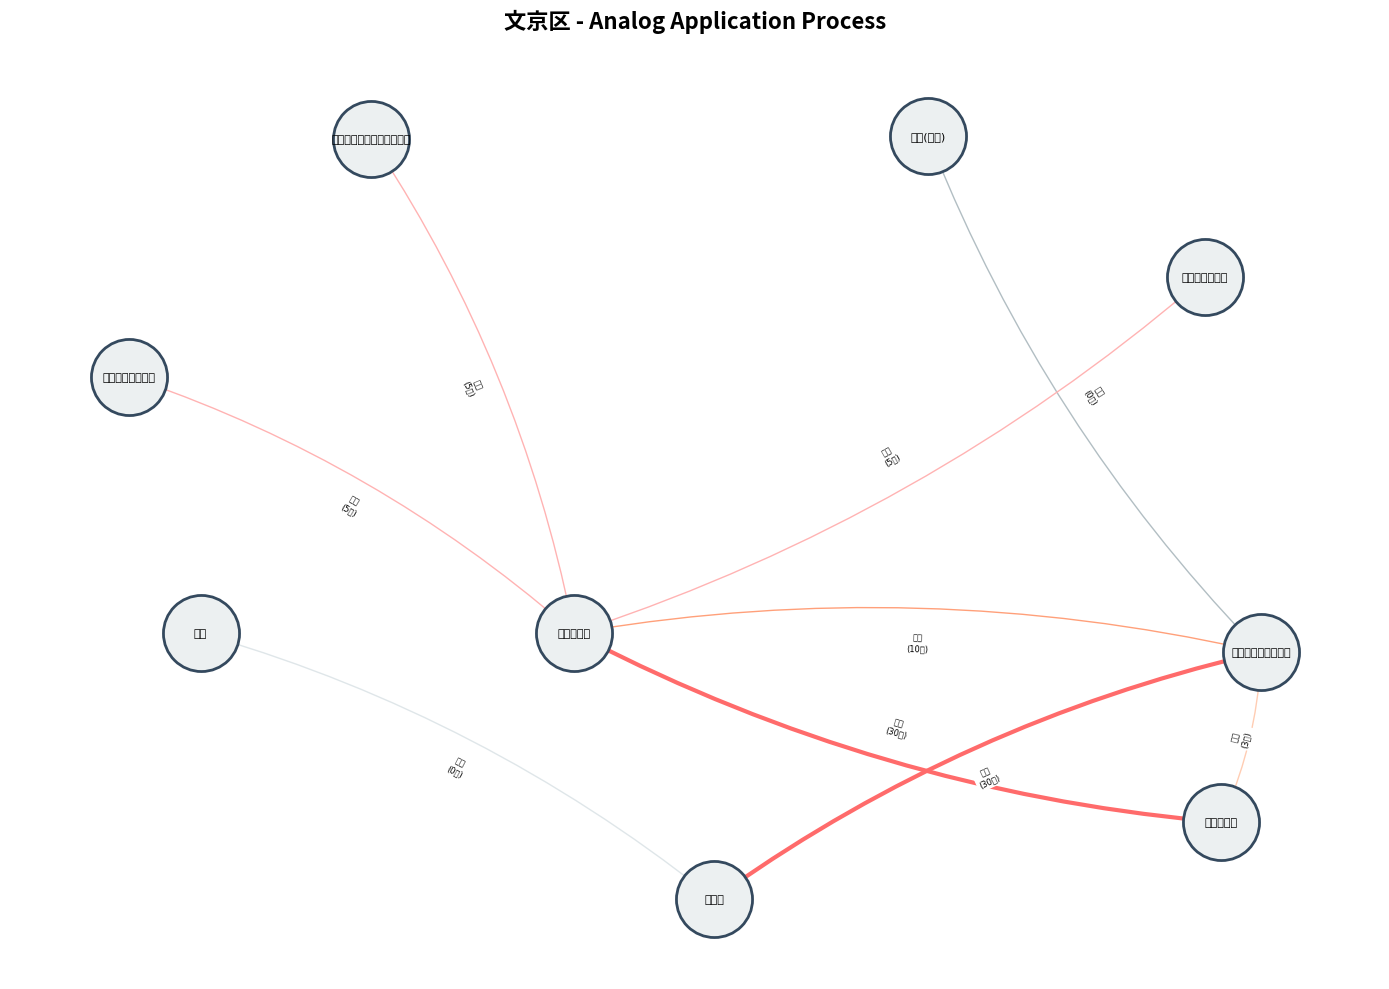

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing

Saved: output/13105_digital_graph.png


/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12408 (\N{HIRAGANA LETTER HE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admi

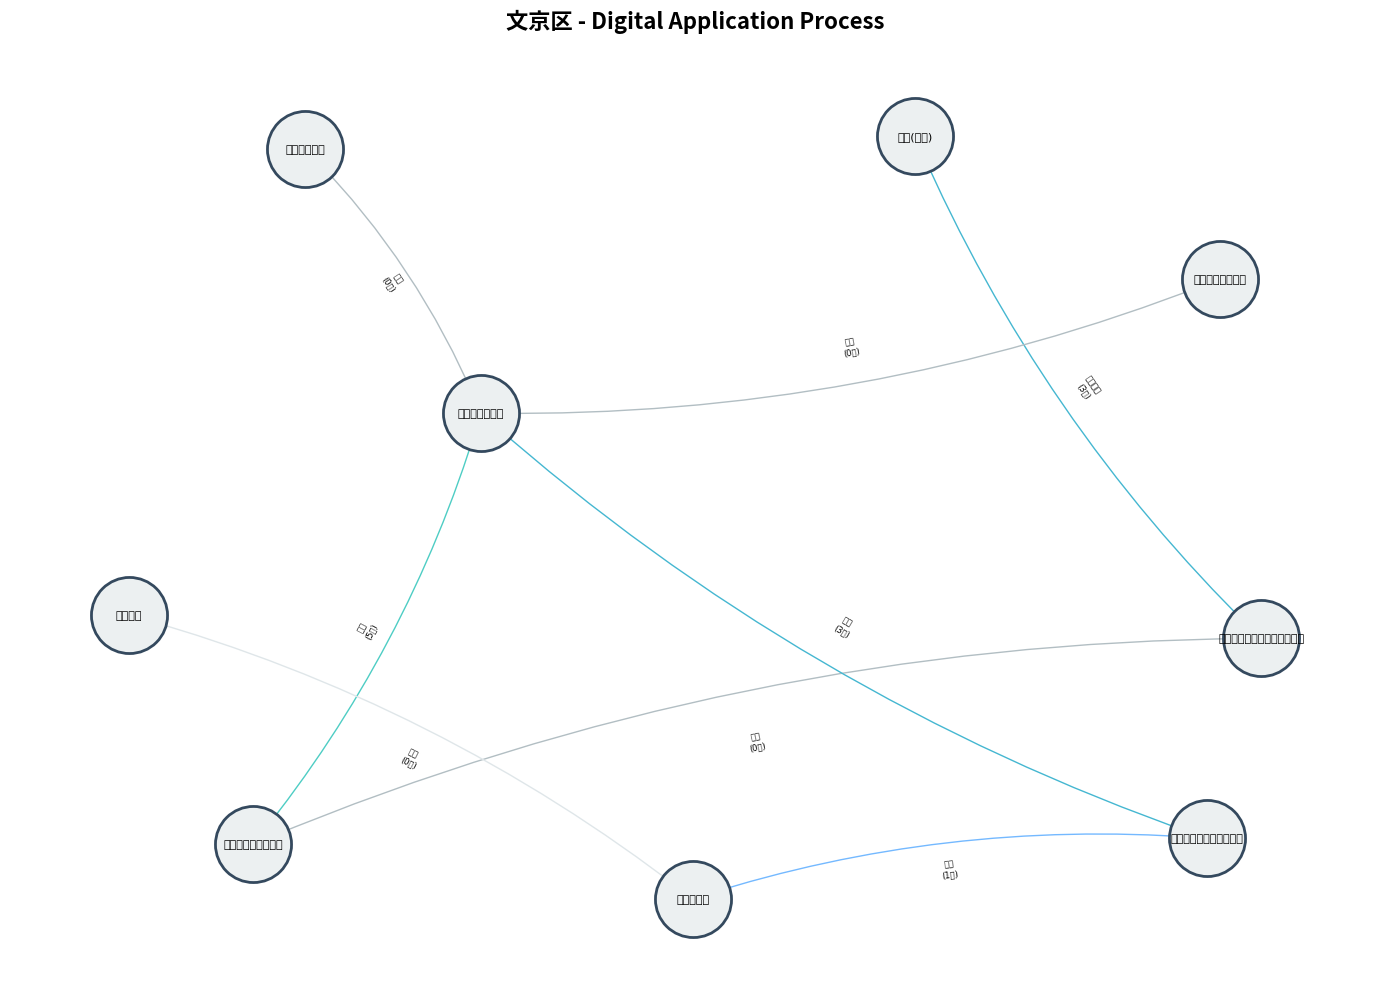

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 38936 (\N{CJK UNIFIED IDEOGRAPH-9818}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 23529 (\N{CJK UNIFIED IDEOGRAPH-5BE9}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 26619 (\N{CJK UNIFIED IDEOGRAPH-67FB}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/tmp/ipykernel_35832/3273809604.py:39: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  plt.savefig(output_file, dpi=300, bbox_inches="tight")
/tmp/ipykernel_35832/3273809604.py:39: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from 

Saved: output/13106_analog_graph.png


/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23529 (\N{CJK UNIFIED IDEOGRAPH-5BE9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ro

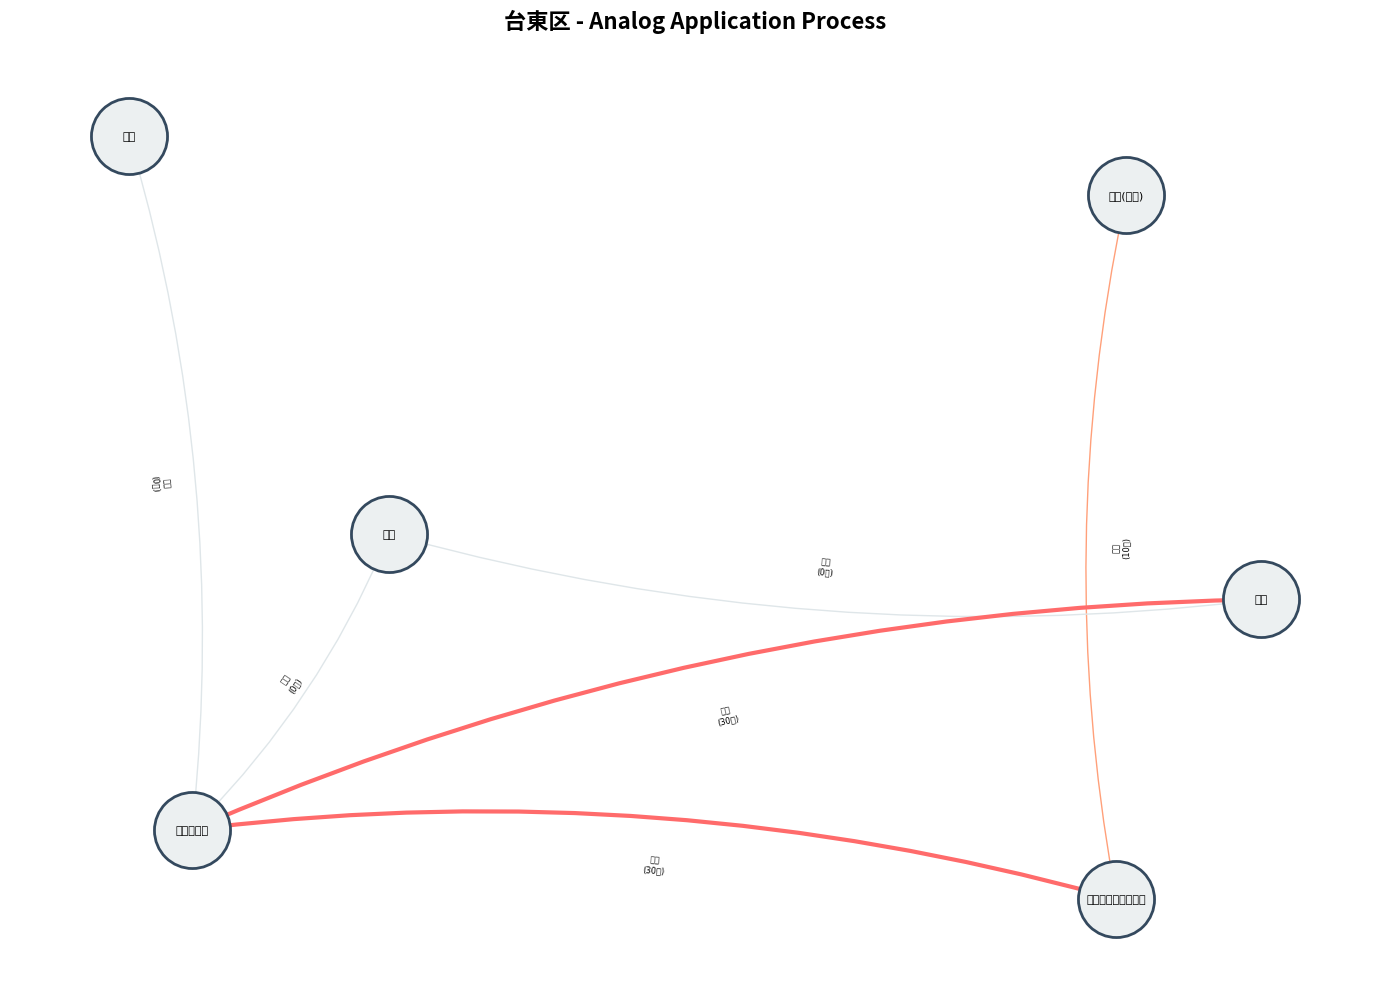

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 36984 (\N{CJK UNIFIED IDEOGRAPH-9078}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 25246 (\N{CJK UNIFIED IDEOGRAPH-629E}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 25658 (\N{CJK UNIFIED IDEOGRAPH-643A}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/tmp/ipykernel_35832/3273809604.py:39: UserWarning: Glyph 20303 

Saved: output/13106_digital_graph.png


/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20303 (\N{CJK UNIFIED IDEOGRAPH-4F4F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ro

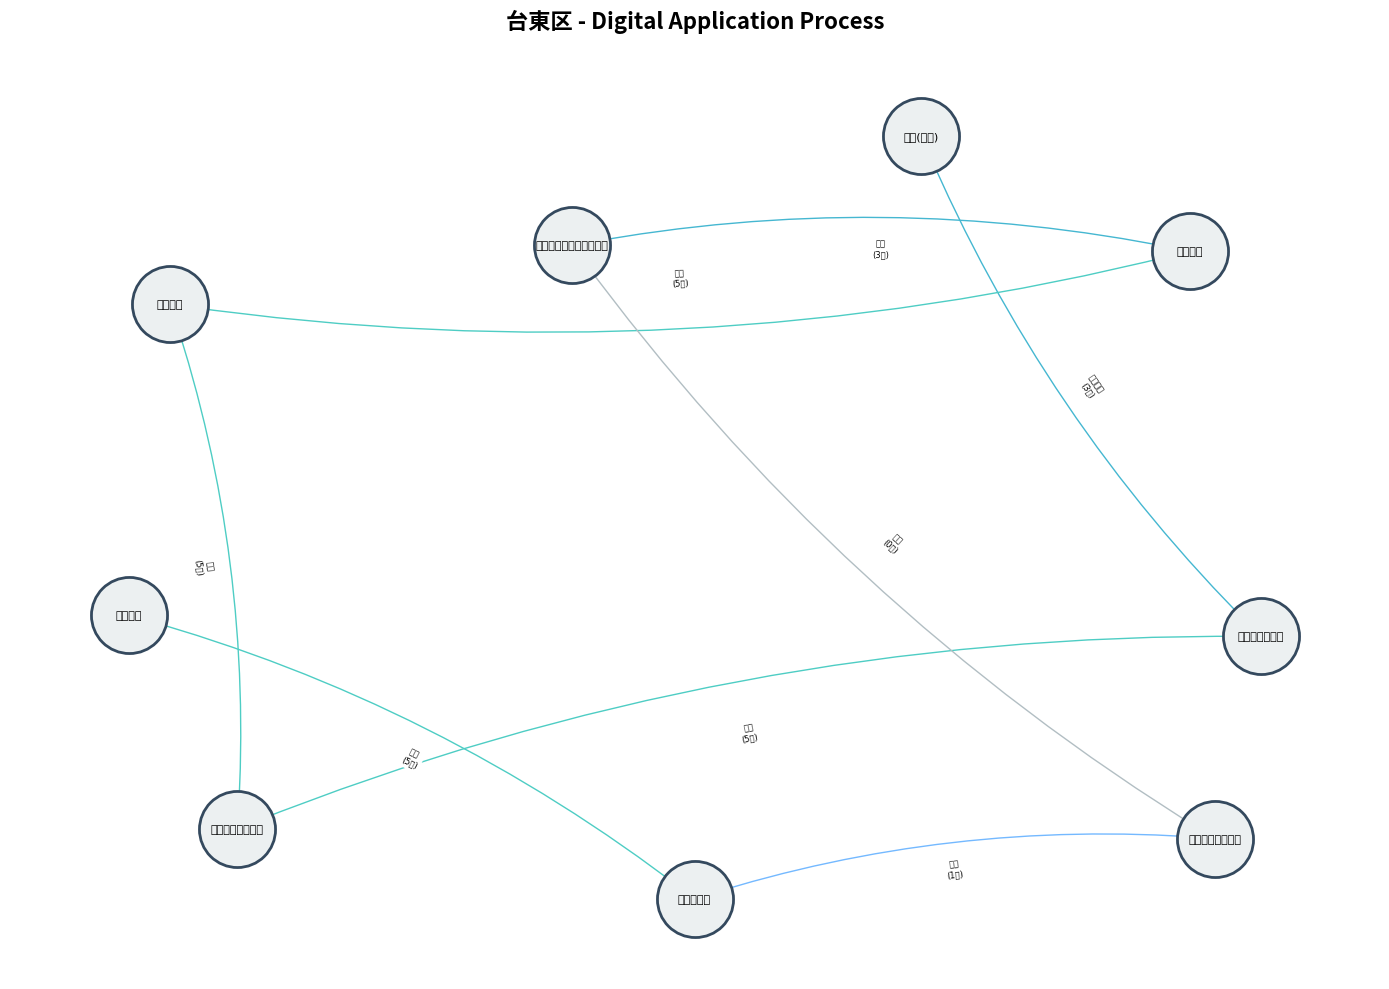

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 25276 (\N{CJK UNIFIED IDEOGRAPH-62BC}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 21360 (\N{CJK UNIFIED IDEOGRAPH-5370}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/tmp/ipykernel_35832/3273809604.py:39: UserWarning: Glyph 36890 

Saved: output/47201_analog_graph.png


/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36890 (\N{CJK UNIFIED IDEOGRAPH-901A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24115 (\N{CJK UNIFIED IDEOGRAPH-5E33}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21360 (\N{CJK UNIFIED IDEOGRAPH-5370}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37969 (\N{CJK UNIFIED IDEOGRAPH-9451}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


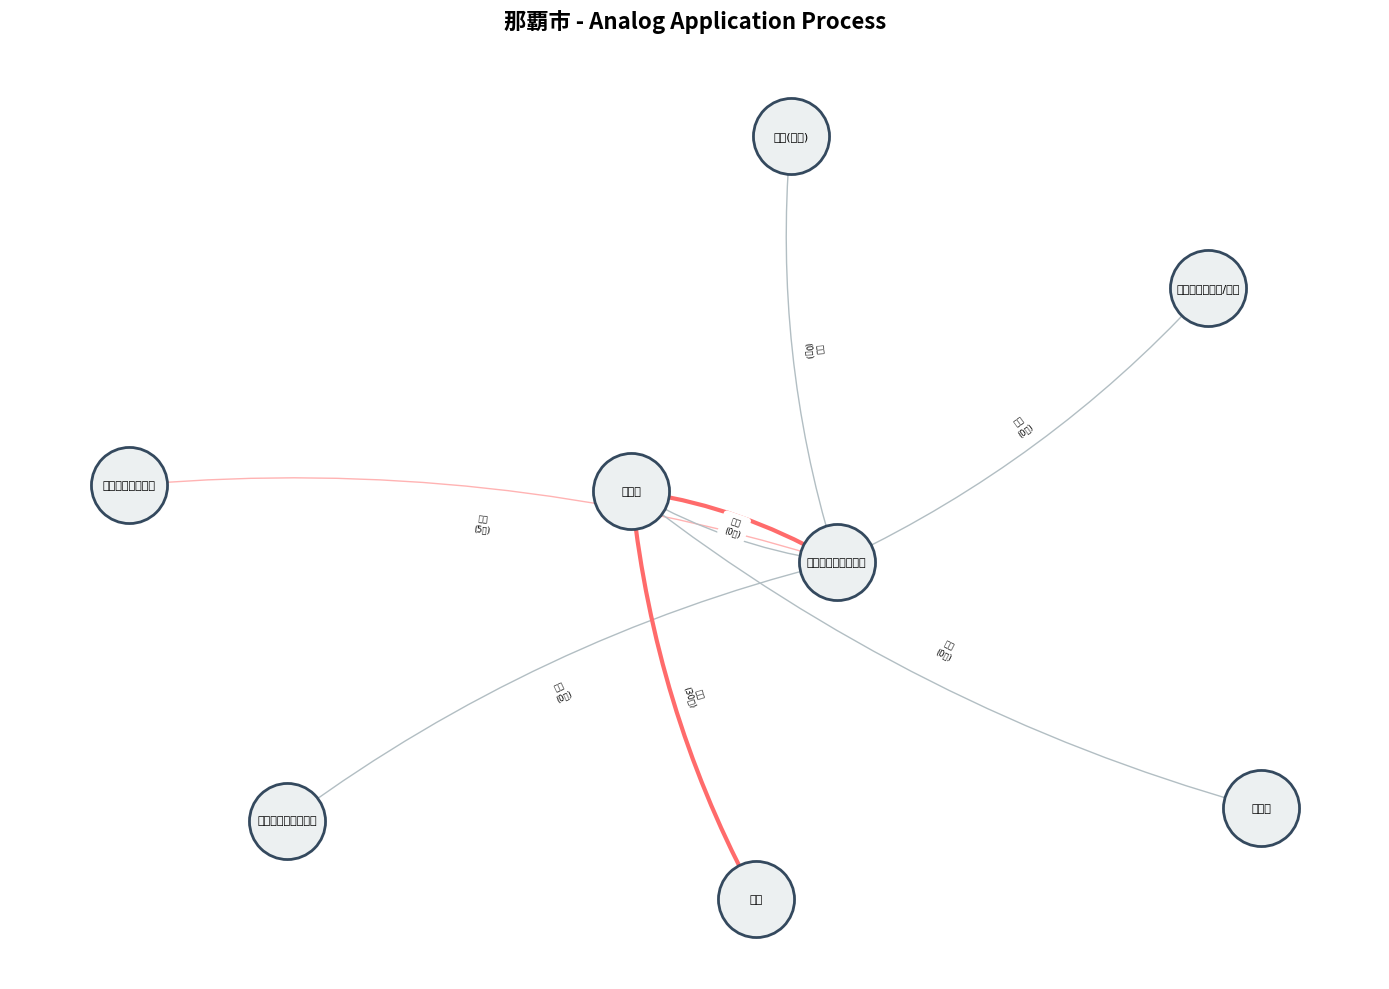

/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12475 (\N{KATAKANA LETTER SE}) missing from font(s) DejaVu Sans.
  super().draw(renderer)
/home/rorok/eeic_lectures/3a/superD/admin-proc/.venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:1439: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  super().draw(renderer)


Saved: output/47201_digital_graph.png


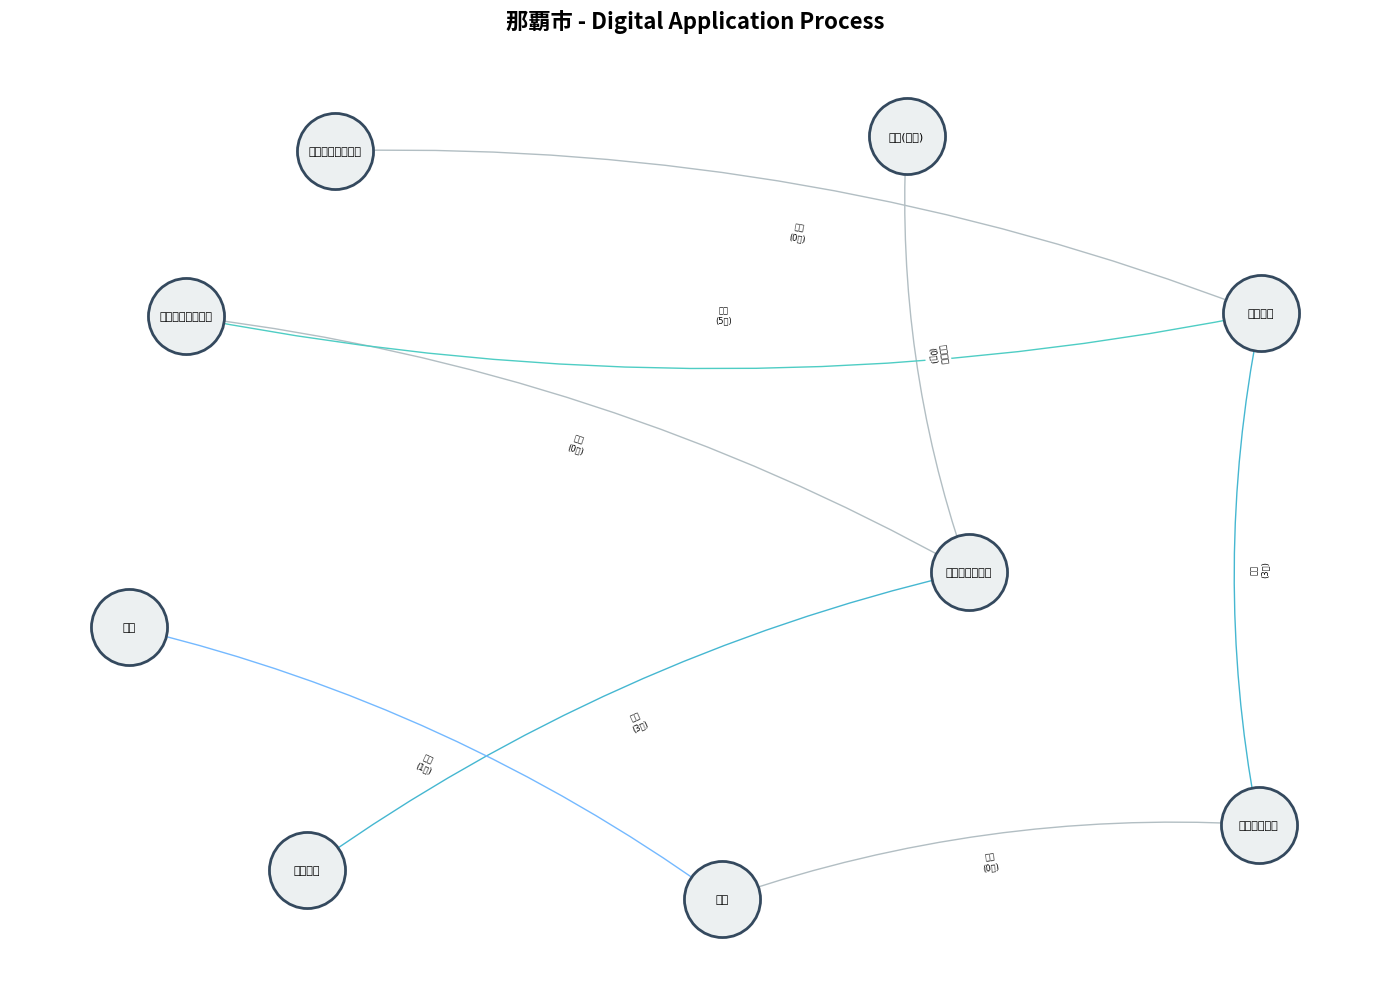

In [ ]:
def visualize_graph(G: nx.DiGraph, title: str, output_file: str = None):
    """グラフを可視化"""
    plt.figure(figsize=(14, 10))
    
    # レイアウト計算
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # エッジの色をタイプに応じて設定
    edge_colors = []
    edge_widths = []
    for u, v, data in G.edges(data=True):
        action_type = data.get("type", "No_Action")
        edge_colors.append(TYPE_COLORS.get(action_type, "#95A5A6"))
        # コストに応じてエッジの太さを変更
        cost = data.get("cost", 0)
        edge_widths.append(max(1, cost / 10))
    
    # ノード描画
    nx.draw_networkx_nodes(G, pos, node_color="#ECF0F1", node_size=3000, 
                          edgecolors="#34495E", linewidths=2)
    
    # エッジ描画
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths,
                          arrowsize=20, arrowstyle="->", connectionstyle="arc3,rad=0.1")
    
    # ラベル描画
    nx.draw_networkx_labels(G, pos, font_size=8, font_family="DejaVu Sans")
    
    # エッジラベル（アクション名）
    edge_labels = {(u, v): f"{data['action']}\n({data['cost']}分)" 
                   for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    
    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.axis("off")
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved: {output_file}")
    
    plt.show()

# 各自治体のグラフを可視化
for city_id, data in all_data.items():
    city_name = data["name"]
    
    # アナログ申請グラフ
    visualize_graph(
        data["analog_graph"],
        f"{city_name} - Analog Application Process",
        f"output/{city_id}_analog_graph.png"
    )
    
    # デジタル申請グラフ
    visualize_graph(
        data["digital_graph"],
        f"{city_name} - Digital Application Process",
        f"output/{city_id}_digital_graph.png"
    )

## 4. コスト比較分析

In [ ]:
# サマリーテーブル作成
summary_data = []
for city_id, data in all_data.items():
    summary_data.append({
        "自治体": data["name"],
        "アナログコスト(分)": data["analog_cost"],
        "デジタルコスト(分)": data["digital_cost"],
        "削減時間(分)": data["analog_cost"] - data["digital_cost"],
        "削減率(%)": data["reduction_rate"]
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("削減率(%)", ascending=False)
print("\n=== コスト削減サマリー ===")
print(summary_df.to_string(index=False))
summary_df.to_csv(f"{OUTPUT_DIR}/cost_summary.csv", index=False, encoding="utf-8-sig")


=== コスト削減サマリー ===
自治体  アナログコスト(分)  デジタルコスト(分)  削減時間(分)    削減率(%)
文京区          88          12       76 86.363636
那覇市          65          12       53 81.538462
台東区          70          27       43 61.428571


## 5. 詳細分析

### 5.1 要因分解（積み上げ棒グラフ）

Saved: output/cost_breakdown.png


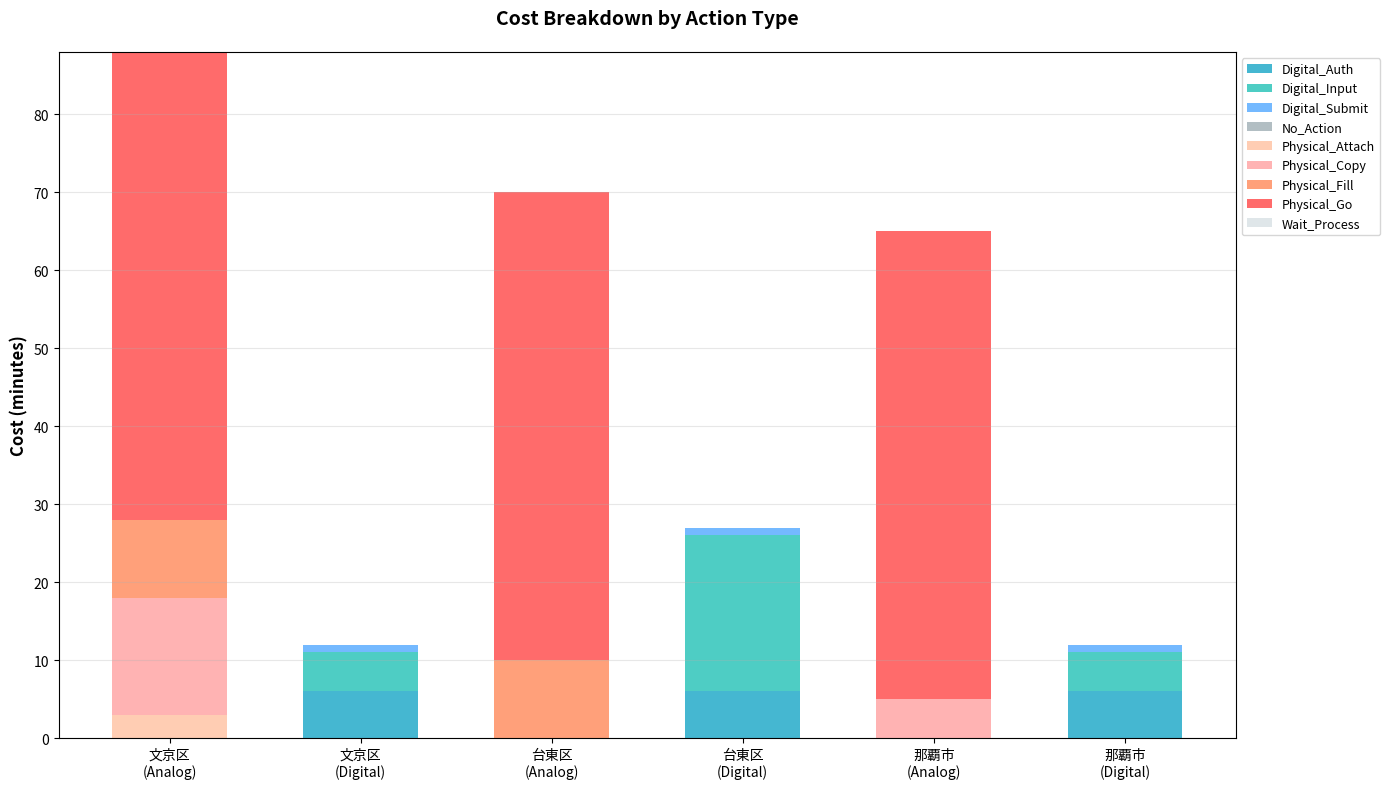

In [ ]:
def plot_cost_breakdown():
    """コスト内訳の積み上げ棒グラフ"""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    city_names = [data["name"] for data in all_data.values()]
    x_labels = []
    for name in city_names:
        x_labels.extend([f"{name}\n(Analog)", f"{name}\n(Digital)"])
    
    x_pos = np.arange(len(x_labels))
    
    # 全アクションタイプを収集
    all_types = set()
    for data in all_data.values():
        all_types.update(data["analog_breakdown"].keys())
        all_types.update(data["digital_breakdown"].keys())
    
    all_types = sorted(all_types)
    
    # 各タイプごとにバーを積み上げ
    bottom = np.zeros(len(x_labels))
    
    for action_type in all_types:
        values = []
        for data in all_data.values():
            values.append(data["analog_breakdown"].get(action_type, 0))
            values.append(data["digital_breakdown"].get(action_type, 0))
        
        color = TYPE_COLORS.get(action_type, "#95A5A6")
        ax.bar(x_pos, values, bottom=bottom, label=action_type, color=color, width=0.6)
        bottom += values
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.set_ylabel("Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_title("Cost Breakdown by Action Type", fontsize=14, fontweight="bold", pad=20)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/cost_breakdown.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {OUTPUT_DIR}/cost_breakdown.png")
    plt.show()

plot_cost_breakdown()

### 5.2 自治体ランキング

Saved: output/reduction_ranking.png


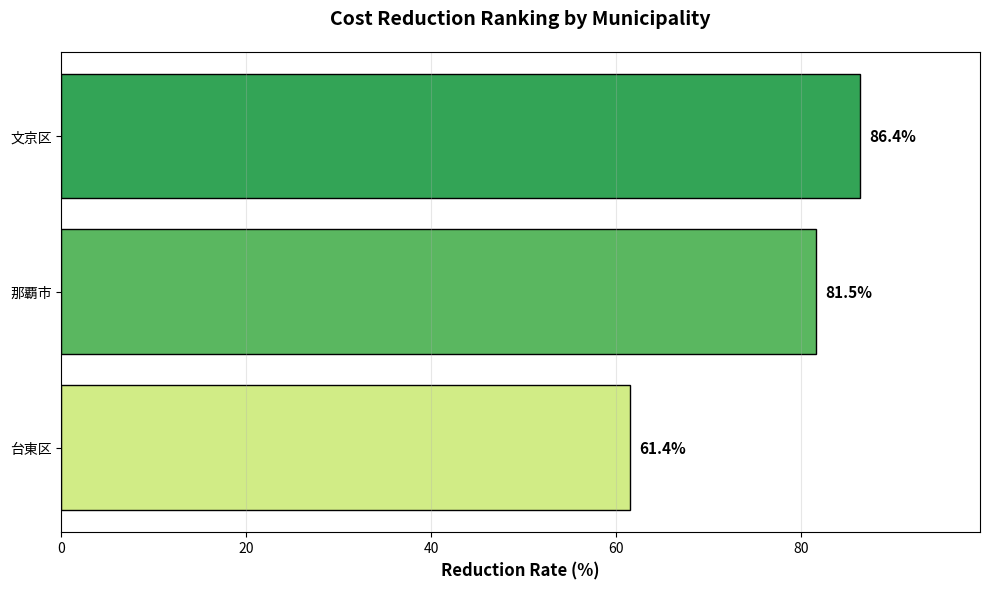

In [ ]:
def plot_reduction_ranking():
    """削減率ランキングの横棒グラフ"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sorted_df = summary_df.sort_values("削減率(%)", ascending=True)
    
    colors = plt.cm.RdYlGn(sorted_df["削減率(%)"] / 100)
    
    bars = ax.barh(sorted_df["自治体"], sorted_df["削減率(%)"], color=colors, edgecolor="black")
    
    # バーに数値ラベルを追加
    for i, (idx, row) in enumerate(sorted_df.iterrows()):
        ax.text(row["削減率(%)"] + 1, i, f"{row['削減率(%)']:.1f}%", 
               va="center", fontsize=11, fontweight="bold")
    
    ax.set_xlabel("Reduction Rate (%)", fontsize=12, fontweight="bold")
    ax.set_title("Cost Reduction Ranking by Municipality", fontsize=14, fontweight="bold", pad=20)
    ax.grid(axis="x", alpha=0.3)
    ax.set_xlim(0, max(sorted_df["削減率(%)"]) * 1.15)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/reduction_ranking.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {OUTPUT_DIR}/reduction_ranking.png")
    plt.show()

plot_reduction_ranking()

### 5.3 散布図（アナログコスト vs デジタルコスト）

Saved: output/scatter_comparison.png


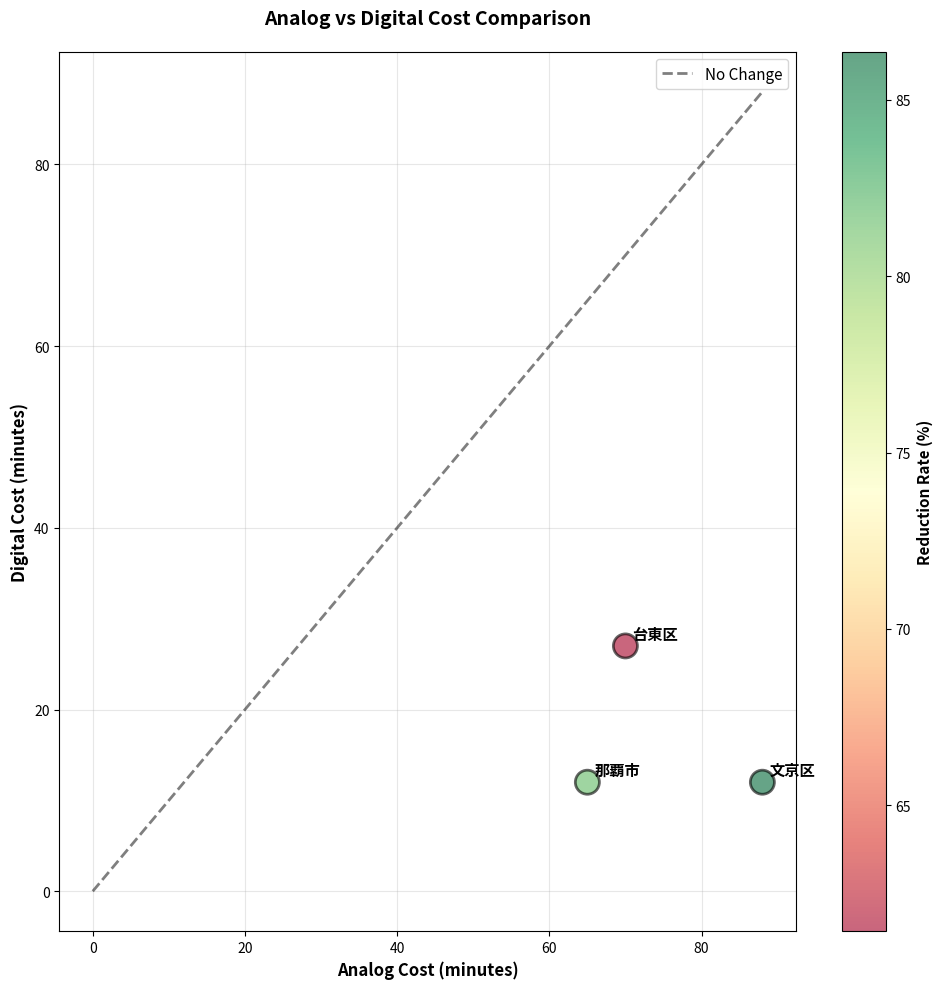

In [ ]:
def plot_scatter_comparison():
    """アナログコスト vs デジタルコストの散布図"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    analog_costs = summary_df["アナログコスト(分)"].values
    digital_costs = summary_df["デジタルコスト(分)"].values
    city_names = summary_df["自治体"].values
    
    # 散布図
    scatter = ax.scatter(analog_costs, digital_costs, s=300, alpha=0.6, 
                        c=summary_df["削減率(%)"], cmap="RdYlGn", 
                        edgecolors="black", linewidth=2)
    
    # 自治体名をラベル表示
    for i, name in enumerate(city_names):
        ax.annotate(name, (analog_costs[i], digital_costs[i]), 
                   xytext=(5, 5), textcoords="offset points", fontsize=11, fontweight="bold")
    
    # 対角線（変化なしのライン）
    max_val = max(analog_costs.max(), digital_costs.max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2, label="No Change")
    
    ax.set_xlabel("Analog Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Digital Cost (minutes)", fontsize=12, fontweight="bold")
    ax.set_title("Analog vs Digital Cost Comparison", fontsize=14, fontweight="bold", pad=20)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=11)
    
    # カラーバー
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Reduction Rate (%)", fontsize=11, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/scatter_comparison.png", dpi=300, bbox_inches="tight")
    print(f"Saved: {OUTPUT_DIR}/scatter_comparison.png")
    plt.show()

plot_scatter_comparison()

## 6. 統計的検定

In [ ]:
from scipy import stats

# 対応のあるt検定（アナログ vs デジタル）
analog_costs = summary_df["アナログコスト(分)"].values
digital_costs = summary_df["デジタルコスト(分)"].values

t_stat, p_value = stats.ttest_rel(analog_costs, digital_costs)

print("\n=== 統計的検定結果 ===")
print(f"対応のあるt検定: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("→ 有意差あり (p < 0.05): デジタル化により有意にコストが削減されています")
else:
    print("→ 有意差なし (p >= 0.05)")

# 基本統計量
print("\n=== 基本統計量 ===")
print(f"アナログコスト: 平均={analog_costs.mean():.1f}分, 標準偏差={analog_costs.std():.1f}分")
print(f"デジタルコスト: 平均={digital_costs.mean():.1f}分, 標準偏差={digital_costs.std():.1f}分")
print(f"平均削減率: {summary_df['削減率(%)'].mean():.1f}%")


=== 統計的検定結果 ===
対応のあるt検定: t=5.869, p=0.0278
→ 有意差あり (p < 0.05): デジタル化により有意にコストが削減されています

=== 基本統計量 ===
アナログコスト: 平均=74.3分, 標準偏差=9.9分
デジタルコスト: 平均=17.0分, 標準偏差=7.1分
平均削減率: 76.4%
